# Setup

Load example data and prepare feature normalization.

In [1]:
from __future__ import annotations

import logging
from typing import Dict, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.datasets import load_boston
from sklearn.metrics import r2_score

from pr3.pursuit import PracticalProjectionPursuitRegressor

In [2]:
sns.set_style('whitegrid')
%matplotlib inline

RANDOM_SEED = 2021
TRG_RATIO = 0.75
np.random.seed(RANDOM_SEED)

In [3]:
boston = load_boston()
print(boston.DESCR)
xcols = boston.feature_names
ycol = "MEDV"

df = pd.DataFrame(
    data=boston.data,
    columns=xcols,
)
df[ycol] = boston.target
trg_idxs = np.random.binomial(1, p=TRG_RATIO, size=df.shape[0]).astype(bool)
trg_df = df.iloc[trg_idxs, :].copy()
tst_df = df.iloc[~trg_idxs, :].copy()

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [4]:
from dataclasses import dataclass

@dataclass
class FeatureNormalizer:
    logarithm: bool = False
    winsorize: bool = False
    zscore: bool = False
    
    _logarithm_cols: Dict[int, float] = None
    _winsorize_extremes: Dict[int, Tuple[float, float]] = None
    _zscore_stats: Dict[int, Tuple[float, float]] = None
    
    HEAVY_TAILED_SKEW: float = 2.0
    CONTINUOUS_UNIQUE_COUNT: int = 5
    LOG_SUMMAND_QUANTILE: float = 0.005
    EXTREME_QUANTILE: float = 0.005
    
    def fit(self, x: np.ndarray) -> FeatureNormalizer:
        x = x.copy()
        if self.logarithm:
            x = self._logarithm_fit(x)._logarithm_transform(x)
        if self.winsorize:
            x = self._winsorize_fit(x)._winsorize_transform(x)
        if self.zscore:
            x = self._zscore_fit(x)._zscore_transform(x)
            
        return self
        
    def transform(self, x: np.ndarray) -> np.ndarray:
        x = x.copy()
        if self.logarithm:
            x = self._logarithm_transform(x)
        if self.winsorize:
            x = self._winsorize_transform(x)
        if self.zscore:
            x = self._zscore_transform(x)
            
        return x
        
    def _logarithm_fit(self, x: np.ndarray) -> FeatureNormalizer:
        skews = ((x - x.mean(axis=0)) ** 3.0).mean(axis=0) / x.var(axis=0) ** 1.5
        self._logarithm_cols = {
            col: np.quantile(x[x[:, col] > 0, col], self.LOG_SUMMAND_QUANTILE)
            for col, skew in enumerate(skews)
            if skew > self.HEAVY_TAILED_SKEW
            and len(np.unique(x[:, col])) > self.CONTINUOUS_UNIQUE_COUNT
            and all(x[:, col] >= 0)
        }
        return self
        
    def _winsorize_fit(self, x: np.ndarray) -> FeatureNormalizer:
        lows = np.quantile(x, q=self.EXTREME_QUANTILE, axis=0)
        highs = np.quantile(x, q=1 - self.EXTREME_QUANTILE, axis=0)
        self._winsorize_extremes = dict(zip(range(x.shape[1]), zip(lows, highs)))
        return self
        
    def _zscore_fit(self, x: np.ndarray) -> FeatureNormalizer:
        mns = np.mean(x, axis=0)
        sds = np.std(x, axis=0)
        self._zscore_stats = dict(zip(range(x.shape[1]), zip(mns, sds)))
        return self
        
    def _logarithm_transform(self, x: np.ndarray) -> np.ndarray:
        if self._logarithm_cols is None:
            raise AttributeError("Log transform not yet fit on training data.")
        for col, quantile in self._logarithm_cols.items():
            x[:, col] = np.log(quantile + x[:, col])
        return x
    
    def _winsorize_transform(self, x: np.ndarray) -> np.ndarray:
        if self._winsorize_extremes is None:
            raise AttributeError("Winsorization transform not yet fit on training data.")
        for col, extremes in self._winsorize_extremes.items():
            x[:, col] = np.clip(x[:, col], extremes[0], extremes[1])
        return x
    
    def _zscore_transform(self, x: np.ndarray) -> np.ndarray:
        if self._zscore_stats is None:
            raise AttributeError("Z-score transform not yet fit on training data.")
        for col, stats in self._zscore_stats.items():
            x[:, col] = (x[:, col] - stats[0]) / stats[1]
        return x

# Model fitting

Test R2: 0.861


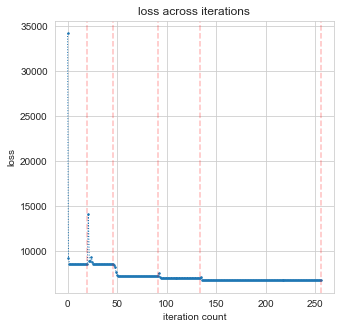

In [5]:
f = FeatureNormalizer(logarithm=True, winsorize=False, zscore=True)
trg_x = f.fit(trg_df[xcols].values).transform(trg_df[xcols].values)
trg_y = trg_df[ycol].values

ppr = PracticalProjectionPursuitRegressor(
    n_stages=5,
    learning_rate=0.5,
    ridge_function_class="polynomial",
    ridge_function_kwargs=dict(degree=3),
    projection_optimizer_class="least_angle",
    projection_optimizer_kwargs=dict(max_iter=3),
    random_state=RANDOM_SEED,
).fit(trg_x, trg_y)
ppr.plot_losses()
tst_df['yhat'] = ppr.predict(f.transform(tst_df[xcols].values))
print(f"Test R2: {r2_score(tst_df[ycol], tst_df['yhat']):0.3f}")

# Model visualization

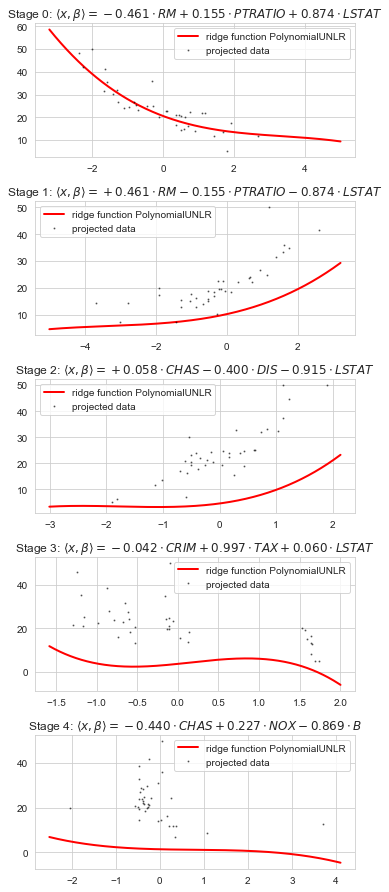

In [6]:
ppr.plot(trg_x, trg_y, feature_names=xcols, fig_height=2.5, fig_width=5.0)

# TODO:

Add commentary for plots:

* explain that latter stages fit against residuals, hence not a perfect fit to projected data;
* discuss why the sparsity is so helpful;
* warn about _post hoc_ "just so" stories.